In [52]:
import os


def ensure_and_move_to_folder(folder_name):
  current_dir = os.getcwd()
  target_path = os.path.join(current_dir, folder_name)

  if not os.path.exists(target_path):
    os.makedirs(target_path)
    print(f"Folder '{folder_name}' created successfully.")
  else:
    print(f"Folder '{folder_name}' already exists.")

  #os.chdir(target_path)

In [53]:
folder_name = '数理最適化'
ensure_and_move_to_folder(folder_name)

path = os.getcwd()

try:
    os.chdir('../VSCode2/数理最適化')
except:
    pass

os.getcwd()

Folder '数理最適化' already exists.


'/Users/takanohiroshi/Library/CloudStorage/OneDrive-YokohamaInternationalExchangeAssociation/GitHub/VSCode2/数理最適化'

In [54]:
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import japanize_matplotlib # type: ignore
import pandas as pd # type: ignore

import gspread # type: ignore
from google.oauth2.service_account import Credentials # type: ignore

import polars as pl # type: ignore
import numpy as np # type: ignore
import pulp # type: ignore
#from pulp import LpProblem, LpVariable, LpMaximize, LpSum, value

# 認証情報の設定
SERVICE_ACCOUNT_FILE = "my-project-vscode-452201-249bdb033f8c.json"  # JSONファイルのパス
SCOPES = ["https://www.googleapis.com/auth/spreadsheets"]

credentials = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
client = gspread.authorize(credentials)

# スプレッドシートを開く（URLまたはスプレッドシートIDを使用）
#SPREADSHEET_ID = "1Ma7ehT4TAnkUwJjspP-C3mwJA1hYmbJr8B9GJSFI0lU"  # スプレッドシートのID
SPREADSHEET_ID = "1Ma7ehT4TAnkUwJjspP-C3mwJA1hYmbJr8B9GJSFI0lU"
sheet = client.open_by_key(SPREADSHEET_ID).worksheet("Sheet4") # 最初のシートを取得

# データを取得
list_of_lists = sheet.get_all_records()
df = pd.DataFrame(list_of_lists)
df = df.set_index(df.columns[0])

df


,X,Y,Stock
,,,
A,3,3,48
B,1,6,36
Venefit,10,20,


In [55]:
P = df.columns[:2].to_list()
M = df.index[:2].to_list()
stock = dict(df['Stock'][:2])
gain = dict(df.loc['Venefit'][:2])
require = {(p, m): df.loc[m, p] for p in P for m in M}

x = {}
for p in P:
  x[p] = pulp.LpVariable(p, lowBound=0, cat='Continuous')

In [56]:
problem = pulp.LpProblem("Maximize_gain", pulp.LpMaximize)

for m in M:
  for p in P:
    problem += pulp.lpSum([require[(p,m)] * x[p] for p in P]) <= stock[m]

problem += pulp.lpSum([gain[p]*x[p] for p in P])

status = problem.solve()
print(pulp.LpStatus[status])

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/takanohiroshi/.pyenv/versions/3.10.5/lib/python3.10/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/52/k1p3ltss0cx1z00jsbnh_2xr0000gn/T/e1d94e88141f494f8339b3a2cb0817b6-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/52/k1p3ltss0cx1z00jsbnh_2xr0000gn/T/e1d94e88141f494f8339b3a2cb0817b6-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 20 RHS
At line 25 BOUNDS
At line 26 ENDATA
Problem MODEL has 4 rows, 2 columns and 8 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 2 (-2) rows, 2 (0) columns and 4 (-4) elements
0  Obj -0 Dual inf 18.164964 (2)
2  Obj 200
Optimal - objective value 200
After Postsolve, objective 200, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 200 - 2 iterations time 0.002, Presolve 0.00
Option for printingOptions

In [57]:
for p in P:
  print(p, x[p].value())
print("obj=", problem.objective.value())

X 12.0
Y 4.0
obj= 200.0


In [58]:
import polars as pl

In [59]:
# データ取得
stock_df = pl.read_csv('2.tutorial/stocks.csv')
require_df = pl.read_csv('2.tutorial/requires.csv')
gain_df = pl.read_csv('2.tutorial/gains.csv')

In [60]:
stock = dict(zip(stock_df["m"], stock_df["stock"]))
require = dict(zip(zip(require_df["p"],require_df["m"]), require_df["require"]))
gain = dict(zip(gain_df["p"], gain_df['gain']))

In [61]:
P = gain_df['p'].to_list()
M = stock_df['m'].to_list()

In [62]:
#　線形計画問題の定義
problem = pulp.LpProblem('LP', pulp.LpMaximize)

# 変数の定義 整数計算問題は安定して解くことは期待できない
x = pulp.LpVariable.dicts("x", P, lowBound=0, cat='Continuous')

# 生産量は在庫の範囲で行うという制約
for m in M:
    problem += pulp.lpSum(require[p, m] * x[p] for p in P) <= stock[m]

# 目的関数の定義
problem += pulp.lpSum([gain[p]*x[p] for p in P])


In [63]:
status = problem.solve()
print('status', pulp.LpStatus[status])

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/takanohiroshi/.pyenv/versions/3.10.5/lib/python3.10/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/52/k1p3ltss0cx1z00jsbnh_2xr0000gn/T/ac926e6e301c4dd288b60606194165b8-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/52/k1p3ltss0cx1z00jsbnh_2xr0000gn/T/ac926e6e301c4dd288b60606194165b8-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 8 COLUMNS
At line 22 RHS
At line 26 BOUNDS
At line 27 ENDATA
Problem MODEL has 3 rows, 4 columns and 9 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 3 (0) rows, 4 (0) columns and 9 (0) elements
0  Obj -0 Dual inf 17.5 (4)
0  Obj -0 Dual inf 17.5 (4)
4  Obj 80.428571
Optimal - objective value 80.428571
Optimal objective 80.42857143 - 4 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU secon

In [64]:
for p in P:
  print(p, x[p].value())

print('obj=', problem.objective.value())

p1 12.142857
p2 3.5714286
p3 7.4285714
p4 0.0
obj= 80.42857099999999


# 割引クーポンキャンペーンの効果最大化

In [65]:
import pandas as pd
import polars as pu
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl


cust_df = pl.read_csv('4.coupon/customers.csv')
prob_df = pl.read_csv('4.coupon/visit_probability.csv')

In [66]:
print(prob_df.glimpse())

Rows: 16
Columns: 6
$ age_cat    <str> age~19, age~19, age~19, age~19, age20~34, age20~34, age20~34, age20~34, age35~49, age35~49
$ freq_cat   <str> freq0, freq1, freq2, freq3~, freq0, freq1, freq2, freq3~, freq0, freq1
$ segment_id <i64> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
$ prob_dm1   <f64> 0.07, 0.21, 0.28, 0.35, 0.11, 0.32, 0.42, 0.52, 0.08, 0.25
$ prob_dm2   <f64> 0.12, 0.3, 0.39, 0.45, 0.17, 0.43, 0.55, 0.63, 0.14, 0.35
$ prob_dm3   <f64> 0.29, 0.58, 0.74, 0.77, 0.37, 0.72, 0.93, 0.94, 0.33, 0.67



<AxesSubplot:ylabel='Count'>

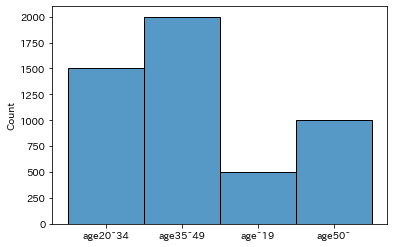

In [67]:
sns.histplot(cust_df['age_cat'].to_list(), bins=5)

# 

<AxesSubplot:ylabel='Count'>

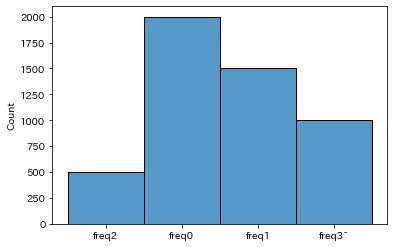

In [68]:
sns.histplot(cust_df['freq_cat'].to_list(),bins=5)

In [69]:
pivot_table_df = cust_df.pivot(
    values="customer_id",
    index="age_cat",
    columns="freq_cat",
    aggregate_fn="count"  # 
)

pivot_table_df = pivot_table_df.sort("age_cat")

age_order = ["age~19", "age20~34","age35~49","age50~"]
order_map = {v: i for i, v in enumerate(age_order)}

pivot_table_df = pivot_table_df.with_columns(pl.col("age_cat").apply(lambda x : order_map.get(x,-1)).alias("sort_order"))
pivot_table_df = pivot_table_df.sort("sort_order").drop("sort_order")

sorted_table = sorted(pivot_table_df.columns)
pivot_table_df = pivot_table_df[sorted_table]

df_pandas = pivot_table_df.to_pandas().set_index('age_cat')
df_pandas

,freq0,freq1,freq2,freq3~
age_cat,,,,
age~19,200,150,50,100
age20~34,600,450,150,300
age35~49,800,600,200,400
age50~,400,300,100,200


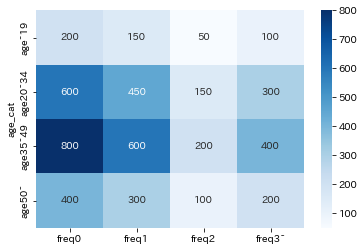

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt


# Heatmapの描画
sns.heatmap(df_pandas, annot=True, fmt='d', cmap='Blues')

plt.show()


In [71]:
df_pandas2 = prob_df.to_pandas()
df_pandas2

,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,age~19,freq0,1,0.07,0.12,0.29
1,age~19,freq1,2,0.21,0.30,0.58
2,age~19,freq2,3,0.28,0.39,0.74
3,age~19,freq3~,4,0.35,0.45,0.77
4,age20~34,freq0,5,0.11,0.17,0.37
5,age20~34,freq1,6,0.32,0.43,0.72
6,age20~34,freq2,7,0.42,0.55,0.93
7,age20~34,freq3~,8,0.52,0.63,0.94
8,age35~49,freq0,9,0.08,0.14,0.33
9,age35~49,freq1,10,0.25,0.35,0.67


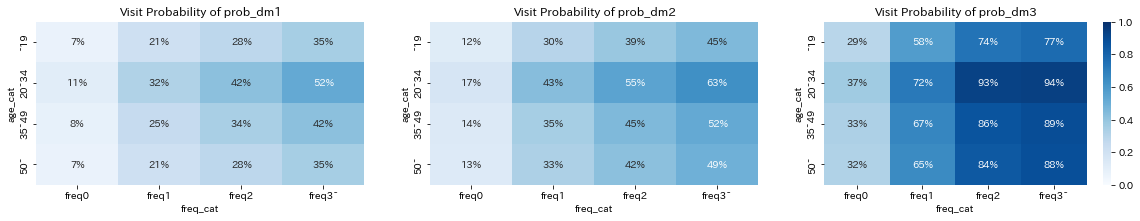

In [72]:
cols = ['age~19','age20~34','age35~49','age50~']
ax = {}
fig, (ax[0],ax[1],ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['prob_dm1', 'prob_dm2','prob_dm3']):
    prob_pivot_df = pd.pivot_table(data=df_pandas2, values=ptn, columns='freq_cat', index='age_cat')
    prob_pivot_df = prob_pivot_df.reindex(cols)
    prob_pivot_df = prob_pivot_df.rename(index=lambda x: x.replace("age",""))
    if i == 2:
        sns.heatmap(prob_pivot_df, vmin=0, vmax=1, annot=True, fmt='.0%', cmap='Blues',ax=ax[i])
    else:
        sns.heatmap(prob_pivot_df, vmin=0, vmax=1, annot=True, fmt='.0%', cmap='Blues',ax=ax[i], cbar=False)
    ax[i].set_title(f'Visit Probability of {ptn}')


* 同じセグメントでは、クーポンの金額が大きいパターンの順に来店率が高くなる。
* 同じ年齢区分では、昨年度の来店回数が多いほどれ来店率が高くなる。
* 同じ昨年度来店回数区分では、age20~34の来店率が高くage~19の来店率が低い。


1. 各会員に対してどのパターンのダイレクトメールを送付するかを決定
2. 各会員に対して送付するダイレクトメールはいずれか１パターン
3. クーポン付与による来客増加数を最大化する
4. 怪異の予算消費期待値の合計は100万円以下
5. 各パターンのダイレクトメールをそれぞれのセグメントに属する会員の10%以下に送付

## モデリング１：会員別送付モデル


In [73]:
import pulp

problem = pulp.LpProblem(name='DiscountCouponProblem1', sense=pulp.LpMaximize)

In [74]:
I = cust_df['customer_id'].to_list()
M = ['1','2','3']

# (1) 各会員に対してどのパターンのメールを送付するかを決定
xim = {}  # 辞書を初期化
for i in I:
    for m in M:
        xim[i, m] = pulp.LpVariable(name=f'xim({i},{m})', cat='Binary')

len(xim)

15000

In [75]:
# (2) 各会員に対して送付するダイレクトメールはいずれか１パターン
for i in I:
    problem += pulp.lpSum(xim[i,m] for m in M) == 1

In [76]:
# 
keys = ['age_cat','freq_cat']
cust_prob_df = cust_df.join(prob_df, on=keys, how='inner')

cust_prob_df = cust_prob_df.rename({'prob_dm1':'1', 'prob_dm2':'2', 'prob_dm3':'3'})

cust_prob_ver_df = cust_prob_df.melt(
    id_vars=['customer_id'],
    value_vars=['1','2','3'],
    variable_name='dm',
    value_name='prob'
)
cust_prob_ver_df.head()

customer_id,dm,prob
i64,str,f64
1,"""1""",0.42
2,"""1""",0.08
3,"""1""",0.08
4,"""1""",0.07
5,"""1""",0.08


In [77]:
Pim = {
    (row["customer_id"],row["dm"]):row["prob"]
    for row in cust_prob_ver_df.select(["customer_id","dm","prob"]).to_dicts()
}

In [78]:
# クーポン付与による来客増加数を最大化
problem += pulp.lpSum((Pim[i,m] - Pim[i,'1']) * xim[i,m]
                      for i in I for m in ['2','3'])

In [79]:
Cm = {'1':0, '2':1000, '3':2000}

# 顧客の消費する費用の期待値の合計は100万円以下
problem += pulp.lpSum(Cm[m]*Pim[i,m]*xim[i,m] for i in I for m in ['2','3']) <= 1000000

In [80]:
# セグメントのリスト
S = prob_df['segment_id'].to_list()
len(S)

16

In [81]:
# 
cust_prob_df1 = cust_prob_df.to_pandas()
Ns = cust_prob_df1.groupby('segment_id')['customer_id'].count().to_dict()

In [82]:
# 各セグメントとそのセグメントに属する顧客数を対応させる辞書の作成
grouped_df = cust_prob_df.groupby("segment_id").agg([
    pl.col("customer_id").count().alias("count")
])
grouped_df = grouped_df.sort("segment_id")
Ns = dict(zip(grouped_df['segment_id'].to_list(), grouped_df['count'].to_list()))
print(Ns)

{1: 200, 2: 150, 3: 50, 4: 100, 5: 600, 6: 450, 7: 150, 8: 300, 9: 800, 10: 600, 11: 200, 12: 400, 13: 400, 14: 300, 15: 100, 16: 200}


In [83]:
# 会員をキーとして属するセグメントを返す辞書
Si = dict(zip(cust_prob_df['customer_id'].to_list(), cust_prob_df['segment_id'].to_list()))   

In [84]:
# 各パターンのダイレクトメールに属する会員数の１０％以上送付
for s in S:
    for m in M:
        problem += pulp.lpSum(xim[i,m] for i in I if Si[i] == s) >= 0.1*Ns[s]

In [85]:
# 
import time

time_start = time.time()
status = problem.solve()
time_stop = time.time()

print(f'ステータス：{pulp.LpStatus[status]}')
print(f'目的関数値：{pulp.value(problem.objective):.4}')
print(f'計算時間：{(time_stop - time_start):.3}秒')


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/takanohiroshi/.pyenv/versions/3.10.5/lib/python3.10/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/52/k1p3ltss0cx1z00jsbnh_2xr0000gn/T/dfa7dd8e221b4950a6dcd9846a64076a-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/52/k1p3ltss0cx1z00jsbnh_2xr0000gn/T/dfa7dd8e221b4950a6dcd9846a64076a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5054 COLUMNS
At line 85055 RHS
At line 90105 BOUNDS
At line 105106 ENDATA
Problem MODEL has 5049 rows, 15000 columns and 40000 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 326.095 - 0.17 seconds
Cgl0004I processed model has 5049 rows, 15000 columns (15000 integer (15000 of which binary)) and 40000 elements
Cutoff increment increased from 1e-05 to 0.00999
Cbc0038I Initial state - 2 integers unsatisfied sum - 0

In [86]:
send_dm_df = pl.DataFrame([[xim[i,m].value() for m in M] for i in I], columns=['send_dm1', 'send_dm2', 'send_dm3'])
send_dm_df.head()

send_dm1,send_dm2,send_dm3
f64,f64,f64
0.0,1.0,0.0
0.0,1.0,0.0
0.0,1.0,0.0
0.0,1.0,0.0
0.0,1.0,0.0


In [87]:
cust_send_df = cust_df[['customer_id','age_cat','freq_cat']].hstack(send_dm_df)
cust_send_df.head()

customer_id,age_cat,freq_cat,send_dm1,send_dm2,send_dm3
i64,str,str,f64,f64,f64
1,"""age20~34""","""freq2""",0.0,1.0,0.0
2,"""age35~49""","""freq0""",0.0,1.0,0.0
3,"""age35~49""","""freq0""",0.0,1.0,0.0
4,"""age~19""","""freq0""",0.0,1.0,0.0
5,"""age35~49""","""freq0""",0.0,1.0,0.0


In [88]:
cust_send_df2 = cust_send_df.to_pandas()
cust_send_df2.head()

,customer_id,age_cat,freq_cat,send_dm1,send_dm2,send_dm3
0,1,age20~34,freq2,0.0,1.0,0.0
1,2,age35~49,freq0,0.0,1.0,0.0
2,3,age35~49,freq0,0.0,1.0,0.0
3,4,age~19,freq0,0.0,1.0,0.0
4,5,age35~49,freq0,0.0,1.0,0.0


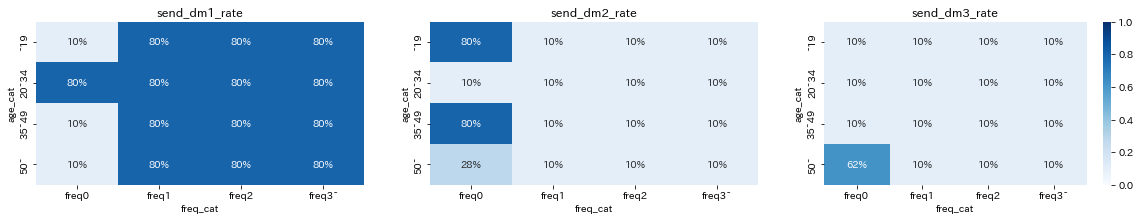

In [89]:
cols = ['age~19','age20~34','age35~49','age50~']
ax = {}
fig, (ax[0],ax[1],ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['send_dm1', 'send_dm2','send_dm3']):
    cust_send_pivot_df = pd.pivot_table(data=cust_send_df2, values=ptn, columns='freq_cat', index='age_cat', aggfunc='mean')
    cust_send_pivot_df = cust_send_pivot_df.reindex(cols)
    cust_send_pivot_df = cust_send_pivot_df.rename(index=lambda x: x.replace("age",""))
    if i == 2:
        sns.heatmap(cust_send_pivot_df, vmin=0, vmax=1, annot=True, fmt='.0%', cmap='Blues',ax=ax[i])
    else:
        sns.heatmap(cust_send_pivot_df, vmin=0, vmax=1, annot=True, fmt='.0%', cmap='Blues',ax=ax[i], cbar=False)
    ax[i].set_title(f'{ptn}_rate')

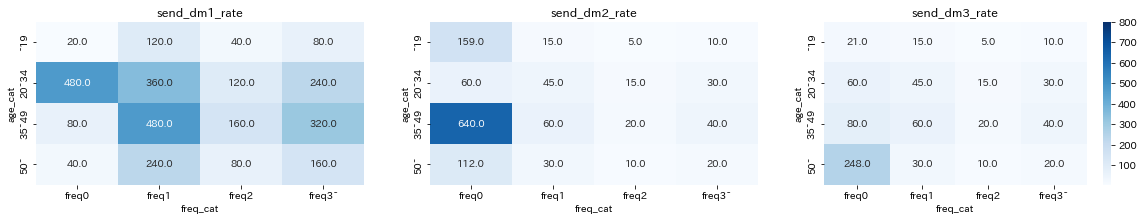

In [90]:
cols = ['age~19','age20~34','age35~49','age50~']
ax = {}
fig, (ax[0],ax[1],ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['send_dm1', 'send_dm2','send_dm3']):
    cust_send_pivot_df = pd.pivot_table(data=cust_send_df2, values=ptn, columns='freq_cat', index='age_cat', aggfunc='sum')
    cust_send_pivot_df = cust_send_pivot_df.reindex(cols)
    cust_send_pivot_df = cust_send_pivot_df.rename(index=lambda x: x.replace("age",""))
    if i == 2:
        sns.heatmap(cust_send_pivot_df, vmax=800, annot=True, fmt='.1f', cmap='Blues',ax=ax[i])
    else:
        sns.heatmap(cust_send_pivot_df, vmax=800, annot=True, fmt='.1f', cmap='Blues',ax=ax[i], cbar=False)
    ax[i].set_title(f'{ptn}_rate')

# モデリング２：セグメント送付モデル


In [91]:
# 数理モデルのインスタンス作成

problem = pulp.LpProblem(name='DiscountCouponProblem2', sense=pulp.LpMaximize)

In [92]:
# 各会員に対してどのパターンのダイレクトメールを送付するかを決定

xsm = {}

#　[0,1]の変数を宣言
for s in S:
    for m in M:
        xsm[s,m] = pulp.LpVariable(name=f'{s}, {m}', lowBound=0, upBound=1, cat='Continuous')
len(xsm)

48

In [93]:
# 各会員に対して送付するダイレクトメールはいずれか１パターン

for s in S:
    problem += pulp.lpSum(xsm[s,m] for m in M)==1

In [94]:
prob_ver_df = prob_df.rename({'prob_dm1':'1', 'prob_dm2':'2', 'prob_dm3':'3'})
prob_ver_df = prob_ver_df.melt(
    id_vars=['segment_id'],
    value_vars=['1','2','3'],
    variable_name='dm',
    value_name='prob'
)
Pam = dict(zip(zip(prob_ver_df['segment_id'].to_list(),prob_ver_df['dm'].to_list()), prob_ver_df['prob']))


In [95]:
# クーポン付与による来客増加数を最大化
problem += pulp.lpSum(Ns[s] * (Pam[s,m] - Pam[s,'1']) * xsm[s,m] for s in S for m in ['2','3'])

In [96]:
# 会員の予算消費期待値の合計は１００万円以下
problem += pulp.lpSum(Cm[m] * Ns[s] * Pam[s,m] * xsm[s,m] for s in S for m in ['2','3']) <= 1000000

In [97]:
# 各パターンのダイレクトメールをそれぞれのセグメントに属する会員数の１０％以上送付
for s in S:
    for m in M:
        problem += xsm[s,m] >= 0.1

In [98]:
# 
import time

time_start = time.time()
status = problem.solve()
time_stop = time.time()

print(f'ステータス：{pulp.LpStatus[status]}')
print(f'目的関数値：{pulp.value(problem.objective):.4}')
print(f'計算時間：{(time_stop - time_start):.3}秒')


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/takanohiroshi/.pyenv/versions/3.10.5/lib/python3.10/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/52/k1p3ltss0cx1z00jsbnh_2xr0000gn/T/64d8b0eaf33645c8ba7d71dd86bf4fcf-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/52/k1p3ltss0cx1z00jsbnh_2xr0000gn/T/64d8b0eaf33645c8ba7d71dd86bf4fcf-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 70 COLUMNS
At line 231 RHS
At line 297 BOUNDS
At line 346 ENDATA
Problem MODEL has 65 rows, 48 columns and 128 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 17 (-48) rows, 32 (-16) columns and 64 (-64) elements
0  Obj 229 Dual inf 981.57657 (32)
6  Obj 326.0951
Optimal - objective value 326.0951
After Postsolve, objective 326.0951, infeasibilities - dual 11.960784 (3), primal 0 (0)
Presolved model was optimal, full model needs cle

In [138]:
send_dm_df = pl.DataFrame([[xsm[s,m].value() for m in M] for s in S], columns=['send_prob_dm1', 'send_prob_dm2', 'send_prob_dm3'])
seg_send_df = prob_df[['segment_id', 'age_cat','freq_cat']].hstack(send_dm_df)
seg_send_df = seg_send_df.to_pandas()
seg_send_df

,segment_id,age_cat,freq_cat,send_prob_dm1,send_prob_dm2,send_prob_dm3
0,1,age~19,freq0,0.1,0.800000,0.100000
1,2,age~19,freq1,0.8,0.100000,0.100000
2,3,age~19,freq2,0.8,0.100000,0.100000
3,4,age~19,freq3~,0.8,0.100000,0.100000
4,5,age20~34,freq0,0.8,0.100000,0.100000
5,6,age20~34,freq1,0.8,0.100000,0.100000
6,7,age20~34,freq2,0.8,0.100000,0.100000
7,8,age20~34,freq3~,0.8,0.100000,0.100000
8,9,age35~49,freq0,0.1,0.800000,0.100000
9,10,age35~49,freq1,0.8,0.100000,0.100000


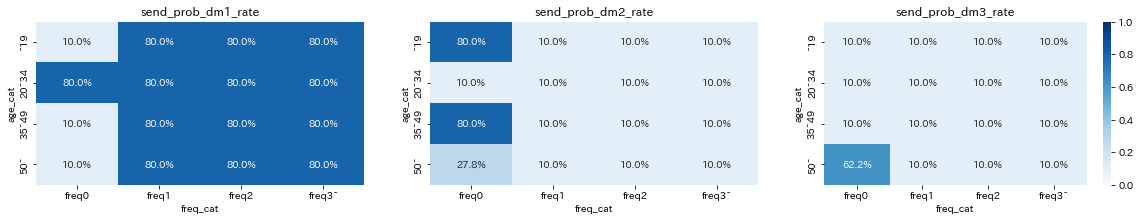

In [139]:
cols = ['age~19','age20~34','age35~49','age50~']
ax={}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['send_prob_dm1','send_prob_dm2','send_prob_dm3']):
    seg_send_pivot_df = pd.pivot_table(data=seg_send_df, values=ptn, columns='freq_cat', index='age_cat', aggfunc='mean')
    seg_send_pivot_df= seg_send_pivot_df.reindex(cols)
    seg_send_pivot_df = seg_send_pivot_df.rename(index=lambda x: x.replace("age",""))
    if i == 2:
        sns.heatmap(seg_send_pivot_df, vmin=0, vmax=1, annot=True, fmt='.1%', cmap='Blues',ax=ax[i])
    else:
        sns.heatmap(seg_send_pivot_df, vmin=0, vmax=1, annot=True, fmt='.1%', cmap='Blues',ax=ax[i], cbar=False)
    ax[i].set_title(f'{ptn}_rate')

In [144]:
seg_send_df['num_cust'] = seg_send_df['segment_id'].apply(lambda x: Ns[x])
seg_send_df['send_num_dm1'] = seg_send_df['send_prob_dm1']*seg_send_df['num_cust']
seg_send_df['send_num_dm2'] = seg_send_df['send_prob_dm2']*seg_send_df['num_cust']
seg_send_df['send_num_dm3'] = seg_send_df['send_prob_dm3']*seg_send_df['num_cust']

In [146]:
seg_send_df[['segment_id','send_num_dm1','send_num_dm2','send_num_dm3']]

,segment_id,send_num_dm1,send_num_dm2,send_num_dm3
0,1,20.0,160.000000,20.000000
1,2,120.0,15.000000,15.000000
2,3,40.0,5.000000,5.000000
3,4,80.0,10.000000,10.000000
4,5,480.0,60.000000,60.000000
5,6,360.0,45.000000,45.000000
6,7,120.0,15.000000,15.000000
7,8,240.0,30.000000,30.000000
8,9,80.0,640.000000,80.000000
9,10,480.0,60.000000,60.000000


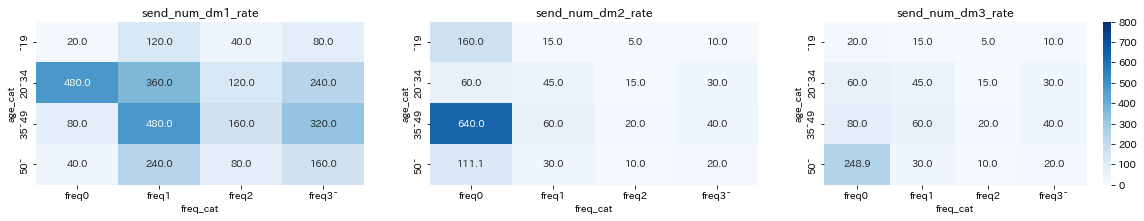

In [148]:
cols = ['age~19','age20~34','age35~49','age50~']
ax={}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['send_num_dm1','send_num_dm2','send_num_dm3']):
    seg_send_pivot_df = pd.pivot_table(data=seg_send_df, values=ptn, columns='freq_cat', index='age_cat')
    seg_send_pivot_df= seg_send_pivot_df.reindex(cols)
    seg_send_pivot_df = seg_send_pivot_df.rename(index=lambda x: x.replace("age",""))
    if i == 2:
        sns.heatmap(seg_send_pivot_df, vmin=0, vmax=800, annot=True, fmt='.1f', cmap='Blues',ax=ax[i])
    else:
        sns.heatmap(seg_send_pivot_df, vmin=0, vmax=800, annot=True, fmt='.1f', cmap='Blues',ax=ax[i], cbar=False)
    ax[i].set_title(f'{ptn}_rate')